# Age Estimation Model

**Annotation:**

The project **aims** to develop a deep Convolutional Neural Network for age estimation based on the ResNet50 model. The following steps will be taken to achieve this:

1. Data Pre-processing
2. Exploratory Analysis
3. Data Preparation for Machine Learning
4. Model Selection and Training Algorithm
5. Training, Testing, and Model Evaluation

Aligned with the customer’s business objectives, the project involves creating a regression model to enable the retail chain to implement a computer vision system for estimating customer ages based on facial images.

**Data Source:**

The study utilizes the APPA-REAL dataset, a comprehensive face image database containing 7591 images, each accompanied by corresponding age tags.

# Определение возраста покупателей

**Аннотация проекта**

На наборе изображений лиц из датасета APPA-REAL проводится исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит бизнесу внедрить систему компьютерного зрения для определения возраста покупателей по изображению.

**Бизнес запрос:** 

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования** — построить модель, которая по изображению определит приблизительный возраст человека. Для этого будут выполнены следующие шаги:

- Исследовательский анализ.
- Подготовка данных для машинного обучения.
- Выбор модели и алгоритма её обучения.
- Обучение, настройка, тестирование и оценка качества модели.
- Прогноз и выводы.

Учитывая бизнес-задачи заказчика, предстоит **решить задачу регрессии**. Число в ответе — это количество лет. Прогноз и верный ответ можно сравнить: чем дальше предсказание от реального ответа, тем оно хуже.

**Согласно условиям** показатель метрики качества модели *MAE* должен составлять не больше 8.

**Описание данных:**

Исследование проводится на примере датасета APPA-REAL, который содержит 7591 изображение с соответствующими метками возраста.

In [1]:
# импорт библиотек, модулей и функций
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных

**На данном этапе проведём исследовательский анализ набора изображений**

In [2]:
# загрузка данных и подготовка генератора данных для обучения модели
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# оценим размер данных
labels.shape

(7591, 2)

In [4]:
# выведем первые пять строк
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# выведем основную информацию о таблице
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Вывод:**
- Данные загружены и корректно отображаются в таблице.
- Датафрейм содержит 7591 образец (строку) с двумя столбцами, что указывает на относительно небольшую выборку.
- Количество значений в столбцах не различается.
- Тип данных соответсвует содержанию.

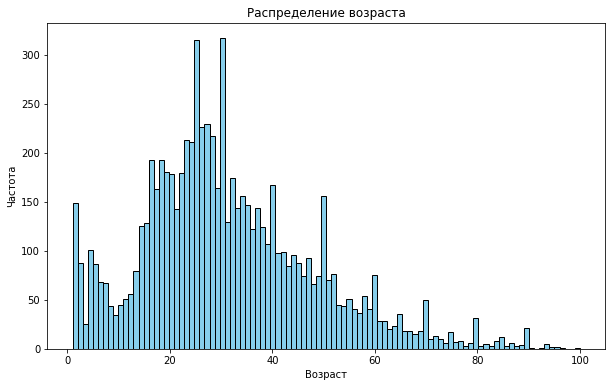

In [6]:
# построим график распределения возраста в выборке
ages = labels['real_age']

plt.figure(figsize=(10, 6))
plt.hist(ages, bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

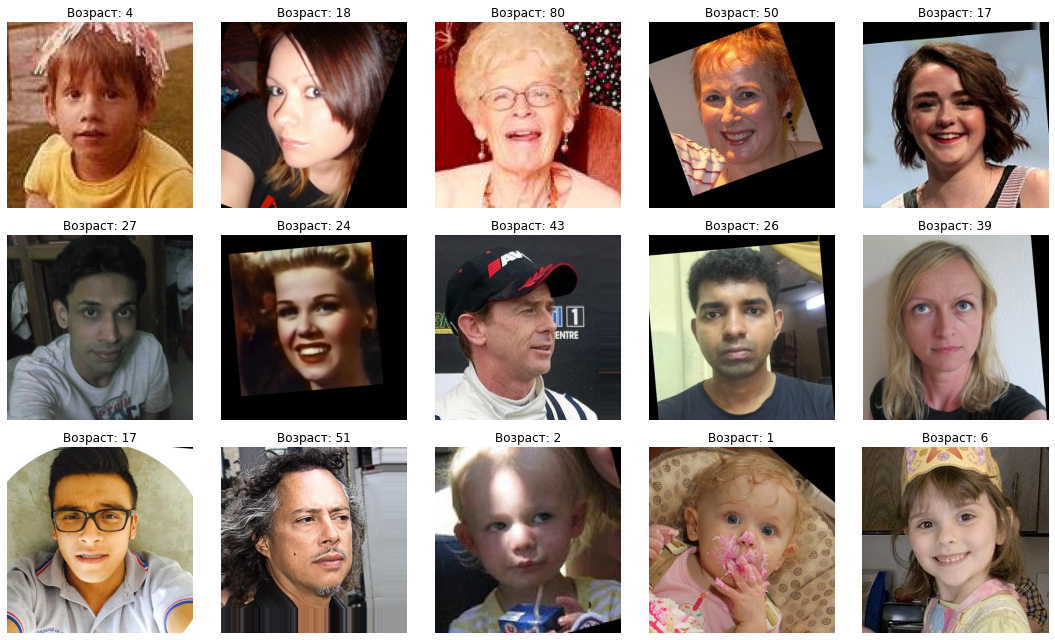

In [7]:
# рассмотрим экземпляры изображений датасета
file_names = labels['file_name'].values[:15]
real_ages = labels['real_age'].values[:15]

# настроим график для отображения фото
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

# цикл для загрузки и отображения изображений с метками возраста
for i, (file_name, real_age) in enumerate(zip(file_names, real_ages)):
    # загрузка и отображение фото
    img = Image.open('/datasets/faces/final_files/' + file_name)
    axes[i].imshow(img)
    axes[i].set_title(f'Возраст: {real_age}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Вывод:**
- График распределения возраста в выборке напоминает естественную возрастную структуру населения с выделением трех условных групп: лица моложе трудоспособного возраста, трудоспособное население, старшая возрастная группа.
-На графике заметны всплески количества изображений в юбилейные годы 1-25-30-40-50 и т.д. Это может объясняться особенностями подготовки данных, когда точный возраст людей на фото не был известен и разметка производилась на основе субъективных оценок, с округлением приблизительного возраста.
- Наиболее часто встречается возраст в диапазоне от 20 до 40 лет. То есть, возрастные группы представлены неравномерно.
- Обнаруженные особенности данных могут повлиять на обобщающие способности модели и не обеспечивают надежность распознавания лиц.

В этой связи, для корректного обучения модели увеличим разнообразие обучающей выборки с помощью методов **аугментации**. 

Поскольку данные включают изображения лиц, применим техники, которые сохраняют основные характеристики черт лица, но при этом вводят вариации для улучшения способности модели к обобщению, в частности:
- `horizontal_flip` — переворот изображений по горизонтали для ввода дополнительных вариаций без изменения основной структуры лица;
- `rotation_range` — слегка повернём изображения, чтобы имитировать изменения положения головы;
- `zoom_range` — масштабирование, чтобы помочь модели научиться распознавать лица в разных масштабах;
- `brightness_range` — изменим яркость и контрастность для имитации различных условий освещения.

## Обучение модели

**На данном этапе построим и обучим свёрточную нейронную сеть** (CNN) для оценки возраста по изображениям лиц на примере датасета APPA-REAL. Для этого используем четыре функции:
- Функции загрузки данных: **load_train()** и **load_test()** загружают данные обучения и тестирования соответственно. Для загрузки изображений из каталога и генерации пакетов аугментированных данных используется `ImageDataGenerator` Keras.
- Функция создания модели: **create_model()** определяет архитектуру модели глубокого обучения. В качестве основы используется предварительно обученная модель `ResNet50` и добавляет слой глобального среднего пула, за которым следует плотный слой с активацией `ReLU` для прогнозирования возраста.
- Функция обучения модели: **train_model()** обучает модель, используя тренировочные данные, далее компилирует модель с потерями среднеквадратической ошибки `(MSE)` и метрикой средней абсолютной ошибки `(MAE)`, а затем подгоняет модель к обучающим данным.


*Примечание: код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.*

```python

# функция загрузки обучающей выборки
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,  # using data augmentation
        rotation_range=10,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

# функция загрузки тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)  # no data augmentation for test data
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',  # using 'validation' subset for test data
        seed=12345)

    return test_gen_flow

# функция создания модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# функция обучения и тестирования модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

# результат вывода на экран
Train for 356 steps, validate for 119 steps
Epoch 1/20
2024-03-18 22:22:55.056970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-18 22:22:56.115642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 138s - loss: 210.0054 - mae: 10.4719 - val_loss: 454.5137 - val_mae: 16.0869
Epoch 2/20
356/356 - 105s - loss: 96.9448 - mae: 7.5211 - val_loss: 136.7062 - val_mae: 8.8468
Epoch 3/20
356/356 - 105s - loss: 75.8468 - mae: 6.6777 - val_loss: 83.2328 - val_mae: 6.9930
Epoch 4/20
356/356 - 105s - loss: 59.5181 - mae: 5.9067 - val_loss: 84.2522 - val_mae: 6.7027
Epoch 5/20
356/356 - 105s - loss: 48.4425 - mae: 5.3518 - val_loss: 71.5177 - val_mae: 6.3154
Epoch 6/20
356/356 - 105s - loss: 39.9916 - mae: 4.8802 - val_loss: 115.2371 - val_mae: 8.0651
Epoch 7/20
356/356 - 105s - loss: 37.4282 - mae: 4.7225 - val_loss: 86.3525 - val_mae: 6.8084
Epoch 8/20
356/356 - 105s - loss: 30.5255 - mae: 4.2514 - val_loss: 109.6214 - val_mae: 7.7384
Epoch 9/20
356/356 - 105s - loss: 28.4600 - mae: 4.1221 - val_loss: 68.6774 - val_mae: 6.1260
Epoch 10/20
356/356 - 105s - loss: 23.2826 - mae: 3.7340 - val_loss: 67.9776 - val_mae: 5.9889
Epoch 11/20
356/356 - 105s - loss: 21.4002 - mae: 3.5448 - val_loss: 66.3197 - val_mae: 5.9480
Epoch 12/20
356/356 - 105s - loss: 20.6690 - mae: 3.5043 - val_loss: 76.2187 - val_mae: 6.4878
Epoch 13/20
356/356 - 105s - loss: 18.6577 - mae: 3.3346 - val_loss: 67.5521 - val_mae: 6.0196
Epoch 14/20
356/356 - 105s - loss: 16.9689 - mae: 3.1472 - val_loss: 81.6251 - val_mae: 6.9548
Epoch 15/20
356/356 - 105s - loss: 15.8628 - mae: 3.0417 - val_loss: 65.0306 - val_mae: 5.9645
Epoch 16/20
356/356 - 105s - loss: 15.0920 - mae: 2.9845 - val_loss: 96.1423 - val_mae: 7.7384
Epoch 17/20
356/356 - 105s - loss: 15.0103 - mae: 2.9719 - val_loss: 67.3380 - val_mae: 6.1003
Epoch 18/20
356/356 - 105s - loss: 15.0722 - mae: 3.0170 - val_loss: 70.4163 - val_mae: 6.2451
Epoch 19/20
356/356 - 105s - loss: 15.1578 - mae: 2.9823 - val_loss: 72.8600 - val_mae: 6.1721
Epoch 20/20
356/356 - 105s - loss: 14.5895 - mae: 2.9281 - val_loss: 65.1107 - val_mae: 5.9455
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 65.1107 - mae: 5.9455
Test MAE: 5.9455

```

## Анализ обученной модели и выводы

На наборе изображений лиц из датасета APPA-REAL был проведен исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит бизнесу внедрить систему компьютерного зрения для определения возраста покупателей.

Учитывая бизнес-задачи заказчика, предстояло разработать прогнозную модель и обучить её по изображению лица определять приблизительный возраст человека (задача регрессии).

Работа включала исследовательский анализ данных, обучение модели с подбором гиперпараметров и проверку её производительности.

На этапе **исследовательского анализа** был оценён размер данных, построен график распределения возраста в выборке, рассмотрены экземпляры изображений датасета. Поскольку данные включают изображения лиц, мы применили **техники аугментации**, которые сохраняют основные характеристики черт лица, но при этом вводят вариации для улучшения способности модели к обобщению.

Этап **разработки модели** предполагал построение и обучение свёрточной нейронной сети `(CNN)` с использованием функций загрузки, создания и обучения модели. В качестве основы применялась предварительно обученная модель `ResNet50`.

**Основные результаты:**

Результаты показывают эффективность обучения и проверки модели на 20 эпохах. Производительность модели оценивалась по следующим метрикам:
- **Потеря и MAE** (средняя абсолютная ошибка): потеря представляет собой ошибку между прогнозируемым и фактическим возрастом, при этом MAE дает среднее значение абсолютных различий между прогнозируемым и фактическим возрастом.
- **Потери при проверке и MAE**: эти метрики вычисляются на отдельном наборе данных проверки во время обучения. Они помогают отслеживать производительность модели на незнакомых данных и обнаруживать переобучение.
- **Тест MAE**: после завершения обучения модель оценивается на наборе тестовых данных для получения окончательного показателя производительности, которым в данном случае является средняя абсолютная ошибка (MAE).

Согласно оценкам, модель работает достаточно хорошо. Потери при обучении и проверке уменьшаются с течением времени, что указывает на то, что модель обучается на данных. Итоговый тест **MAE**, равный **5.9455**, предполагает, что в среднем прогнозы модели отклоняются примерно на 5.95 лет, если применять их к незнакомым данным.

Этот результат означает, что уровень производительности модели можно считать удовлетворительным для решения бизнес-задач поставленных заказчиком. В частности, модель способна предсказывать возраст покупателей с умеренной точностью. Вместе с тем, прогнозные способности модели не ограничеваются рамками данного исследования. Модель несомненно имеет потенциал для улучшения с точки зрения настройки параметров при наличии ресурсных возможностей вычисления.